# 'Applied' Exercise

In [1]:
from profk import Dataset
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
normal = {'value': lambda i: int(i) -3, 'prog_qual': lambda i: int(i) -3} # Normalization

In [4]:
# value = 6 corresponds to refusal to answer, 6 nowhere else in data

cable_training = pd.read_csv('./Data/training.csv', na_values=(-999, 6), converters=normal) 
cable_holdout = pd.read_csv('./Data/holdout.csv', na_values=(-999, 6), converters=normal)
cable_all = pd.concat([cable_training, cable_holdout])

In [5]:
CableTrain = Dataset(cable_training)

# Model Estimation & Display

In [6]:
# Extend the sklearn LogisticRegression class to return Standard Errors and T-statistics

class ExtLogisticRegression(LogisticRegression):
    
    def __init__(self):
        
        LogisticRegression.__init__(self)
            
    def tstat(self, estimate, se): return estimate / se
    
    def getStats(self, X, feature_names): # passing X again after fit() is ugly, but unavoidable without serious class amendment.
        
        '''Courtesy of: 
        # https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients
        # The covariance matrix as given by: (X'VX)^-1

        # X: (n x k), X': (k x n)
        # V: (n x n)

        # -> X'VX: (k x k)'''

        n = len(X)
        predictions = np.matrix(self.predict_proba(X))

        # Initiate matrix of 0's, fill diagonal with each predicted observation's variance
        V = np.matrix(np.zeros(shape = (n, n)))

        p_no = predictions[:,0] # array of all p(no buy)
        p_yes = (predictions[:,1]).A1 # flattened array of all p(buy)

        np.fill_diagonal(V, np.multiply(p_no, p_yes)) # n X n 

        # Covariance matrix
        cov = np.linalg.inv(X.T * V * X)

        # Standard errors
        se = np.sqrt(np.diag(cov))
        
        # Check with E-Views output -> ~ok
        
        tstats = pd.Series(map(self.tstat, self.coef_,se))[0]
        
        summary = pd.DataFrame({'Coefficients': list(self.coef_[0]), 'SE': list(se), 't-stat': list(tstats)})  
        summary = summary.set_index(pd.Index(feature_names))
        
        self.summary = summary

In [44]:
drop = ['YES', 'ID', 'age', 'class', 'tele_have', 'd', 'de'] # no theory needed to drop these guys (redundant or irrelevant features)

feature_names = [i for i in cable_training.columns if i not in drop and i != 'buy']
target_name = ['buy']

X, y = CableTrain.getXy(feature_names, target_name)

In [45]:
Model = ExtLogisticRegression()
Model.fit(X, y)

ExtLogisticRegression()

In [46]:
Model.getStats(X, feature_names)

In [47]:
Model.summary

,Coefficients,SE,t-stat
c,0.606557,0.272343,2.227180
age2,0.230406,0.111368,0.846015
age3,0.386097,0.111958,1.417688
age4,0.352442,0.112023,1.294113
age5,-0.033134,0.128998,-0.121663
age6,-0.043382,0.124698,-0.159292
ab,-2.463974,0.105200,-9.047321
c1,-2.141438,0.078651,-7.863022
c2,-0.773961,0.054843,-2.841861
children,0.319314,0.060554,1.172472


In [11]:
# Please see eviews_output for an Eviews comparison; though there may exist some minute differences in
# calculation (esp. for the constant term), we think our estimates are sufficiently to Eviews close to justify moving forward.

# Eviews claims that, since normality conditions only hold asymptotically, a reported t-statistic is erroneous.
# We were unable to find the Eviews derivation of a p-value in a reasonable amount of time; due to the similarity of coefficients
# and SEs across the model elsewhere, we will just assume that the p-values derived from E-views apply here.  We can spend some
# more time tracking down and copying Eviews method if it would be a valuable exercise.

summary = Model.summary
summary = summary.drop('t-stat', axis=1)

eviews_output = pd.read_csv('./eviews_output.csv')
summary['p-value'] = list(eviews_output['Prob\xa0\xa0']) # I have no idea...weird encoding issue

summary

,Coefficients,SE,p-value
c,0.606557,0.272343,0.0246
age2,0.230406,0.111368,0.0229
age3,0.386097,0.111958,0.0057
age4,0.352442,0.112023,0.0043
age5,-0.033134,0.128998,0.9307
age6,-0.043382,0.124698,0.9280
ab,-2.463974,0.105200,0.0000
c1,-2.141438,0.078651,0.0000
c2,-0.773961,0.054843,0.0000
children,0.319314,0.060554,0.0001


# Applied-Like Process Improvement

In [12]:
# Quick notes:  As with the original Applied project, we don't have many sign priors outside of the obvious: 

    # negative sign on price
    # negative sign on income measures (low-class stigma, inferior good - entertainment)
    # negative sign on the price of compliments (price_mc)

# Weaker cases can be made for other beliefs:

    # negative sign on rent (lease agreement forbids installation)
    # negative sign on consumption of disimliar programming (high-brow BBC channels)
    # positive sign on consumption of similar programming (low-brow ITV & CH4)
    
# Elsewhere, cultural differences between the US and UK, as well as the existince of cross directional multiple marginal effects
# within the same variables (kids want tv more than adults, but parents don't want them to watch it) preclude strong
# assumptions about the effect of other demographic information.

# ***This should probably be done in order of prior violation magnitude, but we attempt all drops simultaneously for brevity***

# A minor prior violation on the income measures of EMP_FT and EMP_HWIFE (redundant proxies for income?) suggests a drop of both

# Since program quality is likely proxying an effect like value and it is statistically insignificant, we attempt a drop

# Since we don't have strong priors about the importance of the stat. insignificant Race, we attempt a drop

# price_mc is also insignificant, but we have good reasons from theory to leave it in (price of compliment, correctly signed)

# sex will prove to be insignificant in later rounds of testing; also dropped here for brevity

In [13]:
# As an applied exercise, I think it makes more sense to specify what to include, as opposed to what
# you want to exclude.

features_2 = ['c', 'age2', 'age3', 'age4', 'age5', 'age6', 'ab', 'c1', 'c2', 'children', 'council', 'no_dish',
       'n_videos', 'price', 'price_mc', 'rent', 'sat_have', 'tv-satis', 'value', 'vcr_have', 'bbc1', 'bbc2', 'itv', 'ch4']

In [14]:
X2, y2 = CableTrain.getXy(features_2, target_name)

In [15]:
Model.fit(X2, y2)

ExtLogisticRegression()

In [16]:
Model.getStats(X2, features_2)

In [17]:
eviews_output = pd.read_csv('./eviews_output_final_model.csv')

In [18]:
summary

,Coefficients,SE,p-value
c,0.606557,0.272343,0.0246
age2,0.230406,0.111368,0.0229
age3,0.386097,0.111958,0.0057
age4,0.352442,0.112023,0.0043
age5,-0.033134,0.128998,0.9307
age6,-0.043382,0.124698,0.9280
ab,-2.463974,0.105200,0.0000
c1,-2.141438,0.078651,0.0000
c2,-0.773961,0.054843,0.0000
children,0.319314,0.060554,0.0001


In [19]:
summary = Model.summary
summary = summary.drop('t-stat', axis=1)

eviews_output = pd.read_csv('./eviews_output_final_model.csv')
summary['p-value'] = list(eviews_output['Prob\xa0\xa0']) # weird encoding issue

summary

,Coefficients,SE,p-value
c,0.710048,0.258144,0.0001
age2,0.319995,0.110186,0.0109
age3,0.426188,0.111086,0.0054
age4,0.376864,0.110210,0.0100
age5,-0.133371,0.125621,0.3484
age6,-0.201481,0.117999,0.1037
ab,-2.419159,0.103651,0.0000
c1,-2.036758,0.075391,0.0000
c2,-0.752647,0.053890,0.0000
children,0.200951,0.058194,0.0029


# Final Model Evaluation & Comments:

In [20]:
# Our only remaining prior violation was somewhat weak (we don't have strong beliefs about previous television consumption)
# Our only remaining statistical insignificance gripes are with an age dummy; we should test their joint significance, 
# but programming a Wald-test from scratch seems excessive; we just leave them in for simplicities sake.

FinalModel = Model

# Lets see how the model predicts w.r.t. the training data and hold out:

In [21]:
def getPhat(model, X):
    
    predictions = model.predict_proba(X)
    predictions = [p[1] for p in predictions]
    
    return sum(predictions) / len(predictions)

In [22]:
# Report the average predicted p(buy) and actual p(buy) across the training set

getPhat(FinalModel, X2), y.mean() # Looks good

(0.30302264937012563, 0.30355220667384286)

In [23]:
CableHold = Dataset(cable_holdout)

In [24]:
XH, yH = CableHold.getXy(features_2, target_name)

In [33]:
# Report the average predict p(buy) and actual p(buy) across the holdout

getPhat(FinalModel, XH), yH.mean() # looks ~ok

(0.306791031110274, 0.3229166666666667)

In [26]:
# Our final model looks like it predicts well across our hold-out
# All in all, we think that the Applied-like logisticRegression model is, at least somewhat, believable
# Moving on to what-if questions...

# KFold Cross Validation of a Logistic Regression

In [27]:
from sklearn import model_selection
import random

In [28]:
Cable = Dataset(cable_all)

X, y = Cable.getXy(features_2, target_name)

In [29]:
folds = 5
rstate = 420

kfold = model_selection.KFold(n_splits=folds, random_state=rstate) 
cv_result = model_selection.cross_val_score(LogisticRegression(), X, y, cv=kfold, scoring='accuracy')

cv_result

array([0.73206377, 0.73737821, 0.73250664, 0.74224978, 0.75287865])

In [30]:
# http://t-redactyl.io/blog/2015/10/using-k-fold-cross-validation-to-estimate-out-of-sample-accuracy.html

In [34]:
# What does this result tell us?  Not much in and of itself; 


# ~ 95% CI interval
# Is this normally distributed?

# Central Limit Theorem:

# is n large enough ?
# Since each round of cross validationRegardless, I can be sure that the sample means will be 

cv_means = np.array([])
for i in range(0, 51):
    
    kfold = model_selection.KFold(n_splits=folds,shuffle=True) # Don't supply a seeded randomn state
    cv_result = model_selection.cross_val_score(LogisticRegression(), X, y, cv=kfold, scoring='accuracy')
    
    cv_means = np.append(cv_means, cv_result.mean())

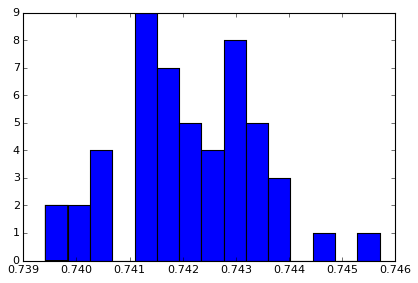

In [35]:
plt.hist(cv_means, bins=15)
plt.show()

In [36]:
std = cv_means.std()
mean = cv_means.mean()

print('~95% CI: ', mean - (1.96 * std), '-', mean + (1.96 * std))

# Is this result decieving me?  Am I actually all that concerned with how well behaved the means of cv tests
# are, or am I singularly concerned with variance around individual estimates

~95% CI:  0.7395785633003641 - 0.7446709026507637


In [37]:
# We're a little confused as to what the result of a  KFold cross validation means in the context of a structural model:

# In Applied, we reserved a holdout over a date range, presumably, on purpose; we were interested in testing wether or not
# we had identified the causal relationships between y and X (the truth).  In a way, we were hoping that modest structural
# change and/or input vector changes *had* taken place between the sample and holdout period, becuase if our model could
# predict well under such circumstances, we could be reasonably confident in the robustness of our model in novel situations.

# In machine learning: f*(x) = E(y | X); f* is the soln of argmin[]

# A Cross Validation test on a purely inferential model, therefore, can't give us an indication of how well the model is likely to
# perform an unknown prediction set; it can only tell us wether structural change and/or input vector changes were present between the K and
# K-1 Folds.  



# Sensitivity to sampling in a structural model (a failure to generalize) means that you have not identifed a general truth.

# Sensitivity to sampling in an inferential framework (a failure to predict Y | X') means only that either 
# f*(X) =/= f**(X') -> structural change or X =/= X' -> no information

# Elasticity Simulation

In [38]:
def getSimulationRange(x, dx):
    
    # Accepts a series and a step: returns an ordered list ranging from the minimum to the maximum of the list
    # in the series, seperated by steps
    
    min_x = min(x)
    max_x = max(x)
    
    r = np.arange(min_x, max_x + dx, dx)
    
    return r

In [39]:
def replaceCol(arr, index, val):
    
    arr[:, index] = val
    return arr

In [40]:
def getElasticity(demand_model, X_arr, price_index, min_price, max_price, dp=1):
    
    p1 = getSimulationRange([min_price, max_price], dp)
    p2 = np.multiply(p1, 1.01)
    delta = []
    
    for price1, price2 in zip(p1, p2):
    
        replaceCol(X_arr, price_index, price1)
        y1 = getPhat(demand_model, X_arr)
    
        replaceCol(X_arr, price_index, price2)
        y2 = getPhat(demand_model, X_arr)
        
        delta.append(y2 - y1)
        
    return p1, p2, delta 

In [41]:
# Note that these are still differences in probabilities, so to obtain demand figures we must assume a market size

price_index = 13

X, y = Cable.getXy(features_2, target_name)

FinalModel.fit(X, y) # no need to waste data


p1, p2, delta = getElasticity(FinalModel, X, price_index, 8, 15, 0.25)

In [42]:
Elasticities = pd.DataFrame({'Price': p1, 'Price Elasticity of Demand': delta})

In [43]:
Elasticities # These are all still in terms of probability differentials, supply a market size for demand estimations

,Price,Price Elasticity of Demand
0,8.00,-0.001380
1,8.25,-0.001418
2,8.50,-0.001455
3,8.75,-0.001491
4,9.00,-0.001527
5,9.25,-0.001562
6,9.50,-0.001596
7,9.75,-0.001631
8,10.00,-0.001664
9,10.25,-0.001697
